In [1]:
import shap
import pickle
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import lightgbm
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from PyALE import ale
from PIL import Image
import io
import warnings

In [2]:
#model_name = 'LGBM_tuned_merged_10outer_100_backup.pkl'
model_name = 'tuned_LGBM_all_features_0035_70trials.pkl'

with open(f'../output/fitted_models/{model_name}', 'rb') as fr:
    model = pickle.load(fr)

In [3]:
np.random.seed(1303)

# Preprocessing

In [9]:
test = pd.read_csv("../input/external.csv")
X_test, y_test = test.drop('symptoms', axis=1), test['symptoms']

X_test = X_test.drop(["site", "infarct_side", "stroke", "TIA"], axis=1)
X_test_nr = X_test.copy()

In [13]:
le = LabelEncoder()
oe = OrdinalEncoder()

to_encode = ["hypertension", "cad", "gender",
             #"TIA", 
             "diabetes", "hyperlipidemia", "smoker_status",
             #"prs_either", 
             #'prs_left', 'prs_right',
             #'calc_and_lipids', 'at_least_5_and_stenosis_either',
             #'at_least_5_and_stenosis_left', 'at_least_5_and_stenosis_right'
            ]

to_ohe = ["calcification_type_left", "calcification_type_right" 
          #'stenosis_risk_left', 'stenosis_risk_right'
         ]
prefixes = ["calcification_left", "calcification_right" 
            #'stenosis_risk_left', 'stenosis_risk_right'
           ]
X_test_nr = pd.get_dummies(X_test_nr, 
                   columns=to_ohe, prefix=prefixes)

y_test = le.fit_transform(y_test)
X_test_nr[to_encode] = oe.fit_transform(X_test_nr[to_encode]).astype(np.uint8)

# convert uint8 dtypes to categorical
cat_cols = X_test_nr.select_dtypes(include=np.uint8).columns.tolist()
X_test_nr[cat_cols] = X_test_nr[cat_cols].astype("category")

In [14]:
columns_map = {
    "calcification_left_Type1": "Type 1 Calcification (L)",
    "calcification_left_Type2": "Type 2 Calcification (L)",
    "calcification_left_Type3": "Type 3 Calcification (L)",
    "calcification_left_Type4": "Type 4 Calcification (L)",
    "calcification_left_Type5": "Type 5 Calcification (L)",
    "calcification_left_Type6": "Type 6 Calcification (L)",
    "calcification_right_Type1": "Type 1 Calcification (R)",
    "calcification_right_Type2": "Type 2 Calcification (R)",
    "calcification_right_Type3": "Type 3 Calcification (R)",
    "calcification_right_Type4": "Type 4 Calcification (R)",
    "calcification_right_Type5": "Type 5 Calcification (R)",
    "calcification_right_Type6": "Type 6 Calcification (R)",
    "at_least_5_and_stenosis_either": "Type 5/6 and > 70% Stenosis",
    "calc_and_lipids": "Calcification and Hyperlipidemia",
    "hypertension": "Hypertension",
    "cad": "CAD",
    "smoker_status": "Smoker",
    "age": "Age",
    "gender": "Male",
    "diabetes": "Diabetes",
    "hyperlipidemia": "Hyperlipidemia",
    "stenosis_left": "Stenosis (L)",
    "stenosis_right": "Stenosis (R)",
    "symptpoms": "Cerebrovascular Events",
    "prs_either": "Positive Rim Sign"
}

In [15]:
X_test_renamed = X_test_nr.rename(columns=columns_map)
X_test_nr = X_test_nr.rename(columns=columns_map)

In [16]:
X_test_fancy = X_test_nr.copy()
bin_features = X_test_fancy.select_dtypes(include="category").columns.tolist()
for c in bin_features:
    X_test_fancy[c] = X_test_fancy[c].apply(lambda v: "Yes" if v == 1 else "No")

# Bootstrap test set and see which features occur the most
a) count how many times a feature have a non-zero SHAP value
b) mean absolute shap value 

In [18]:
from scikits.bootstrap import bootstrap_indices

In [24]:
from collections import defaultdict

bi_gen = bootstrap_indices(X_test_nr, n_samples=5000, seed=1303)
#columns = X_test_subsample.columns
columns = X_test_nr.columns
res = defaultdict(list)

for indices in bi_gen:
    np.random.seed(1303)
    X_test_subsample = X_test_nr.iloc[indices]

    exp = shap.Explainer(model, X_test_subsample) 
    sh = exp(X_test_subsample)
    sh.display_data = X_test_subsample.values
    
    expected_value = exp.expected_value
    if isinstance(expected_value, list):
        expected_value = expected_value[1]
    
    shap_values = sh.abs.mean(0).values
    for i, c in enumerate(columns):
        res[c].append(shap_values[i])

In [25]:
with open(f'../output/results/SHAP_bootstrap.pkl', 'wb') as fw:
    pickle.dump(res, fw)

In [27]:
with open(f'../output/results/SHAP_bootstrap.pkl', 'rb') as fr:
    SHAP_bootstrap = pickle.load(fr)

In [ ]:
# TODO : gather test indices of males vs females and plot dist of SHAP
# values by gender

## Plot distributions of SHAP values across the replications

In [28]:
res_df = pd.DataFrame(SHAP_bootstrap)
medians = res_df.median()
medians.sort_values(ascending=True, inplace=True)
res_df = res_df[medians.index]

# compute CIs
cis = np.zeros((len(SHAP_bootstrap.keys()), 2))

for i, c in enumerate(res_df.columns):
    lower, upper = np.percentile(res_df[c], [2.5, 97.5])
    cis[i] = np.array((lower, upper))

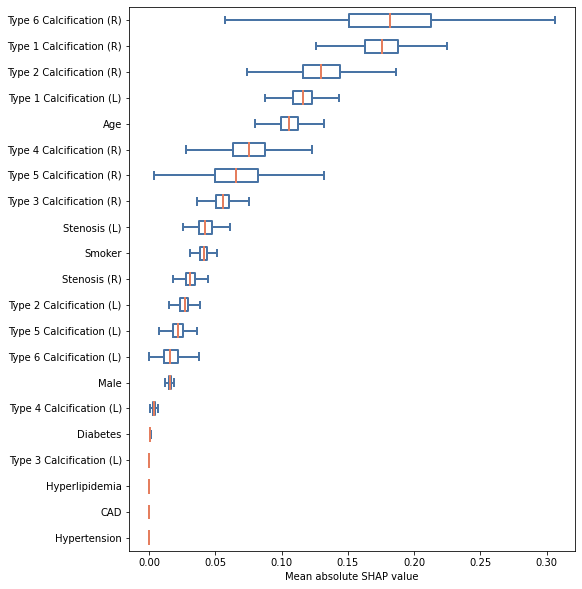

In [32]:
f, ax = plt.subplots(1, 1, figsize=(8, 10))

fliersprops = dict(marker='o', markerfacecolor="white", 
                   markersize=4,                   
                   markeredgecolor="gray",
                   markeredgealpha=0.6 )

boxprops = dict(linewidth=2, color=blue)
medianprops = dict(linewidth=2, color=darksalmon)
whiskerprops = dict(color=blue, linewidth=2)
capprops = dict(linewidth=2, color=blue)

bp = res_df.boxplot(rot=0, grid=False, 
                    vert=False, 
                    conf_intervals=cis,
                    sym='',
                    ax=ax,
                    flierprops=fliersprops,
                    boxprops=boxprops,
                    medianprops=medianprops,
                    whiskerprops=whiskerprops,
                    capprops = capprops,
                    return_type="dict")
ax.set_xlabel("Mean absolute SHAP value")

#plt.savefig("../output/plots/SHAP_bootstrap.pdf", dpi=400, bbox_inches='tight')
plt.savefig("../output/plots/TIFF/SHAP_bootstrap.tiff", format="tiff", dpi=1200, 
            pil_kwargs={"compression": "tiff_lzw"},
            bbox_inches='tight')
plt.show()

# Start SHAPing

In [33]:
np.random.seed(1303)
exp = shap.Explainer(model, X_test_nr) # create the explainer using the same data used for fitting
sh = exp(X_test_nr) # explain unscaled train data without fancy / readable column values
sh.display_data = X_test_renamed.values # associate data for display purposes (readable column names and values)

In [34]:
expected_value = exp.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]

In [30]:
from matplotlib.cm import register_cmap, get_cmap
import matplotlib.colors as clr
blue = "#4974a5"
lightblue = "#b0c4de"
salmon = "#ff8c69"
lightsalmon = "#FFD1C2"
darksalmon = "#e57e5e"

custom_cmap = clr.LinearSegmentedColormap.from_list('custom cmap', [lightblue, salmon], N=256)

## Summary plots: Beeswarm and bar plots

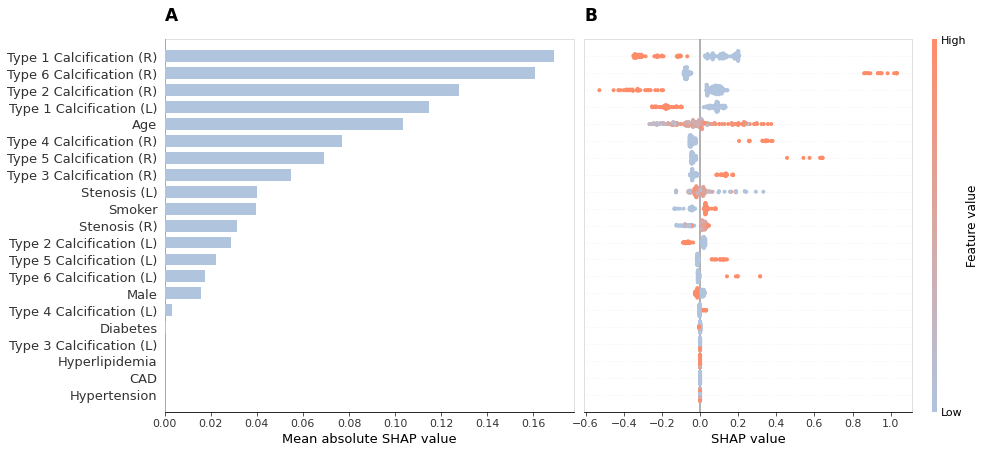

In [35]:
np.random.seed(1303)
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(121)
shap.summary_plot(sh, 
                  plot_type='bar', 
                  show=False, 
                  color="lightsteelblue",
                  max_display=30,
                  plot_size=None)
ax1.set_xlabel("Mean absolute SHAP value")
ax1.patch.set_edgecolor('lightgray')  
ax1.patch.set_linewidth('0.7')  


ax2 = fig.add_subplot(122)

shap.summary_plot(sh, show=False, plot_size=None, cmap=custom_cmap, max_display=30)
ax2.set_xlabel("SHAP value")
#plt.gca().get_yaxis().set_ticks([])
ax2.set_yticks([])
ax2.patch.set_edgecolor('lightgray')  
ax2.patch.set_linewidth('0.7')

plt.tight_layout()


ax1.text(0, 1.05, "A", transform=ax1.transAxes, size=17, weight='bold')
ax2.text(0, 1.05, "B", transform=ax2.transAxes, size=17, weight='bold')

#print(matplotlib.rcParams['font.family'])
#plt.suptitle("Absolute and value-specific variable importance in the ML prediction", x=0.5, y=1.15, fontsize=20, weight="normal")


#plt.savefig("../output/plots/SHAP.pdf", dpi=400, bbox_inches='tight')
plt.savefig("../output/plots/TIFF/SHAP.tiff", format="tiff", dpi=1200, bbox_inches='tight',
           pil_kwargs={"compression": "tiff_lzw"})
plt.show()

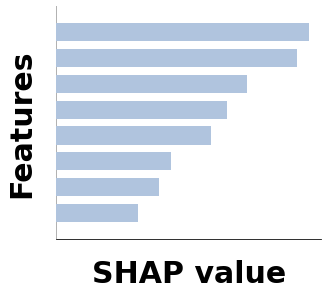

In [37]:
#np.random.seed(1303)
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(121)


shap.summary_plot(sh, 
                  plot_type='bar', 
                  show=False, 
                  color="lightsteelblue",
                  max_display=8,
                  plot_size=None)

ax1.patch.set_edgecolor('lightgray')  
#ax1.patch.set_linewidth('0.7') 

plt.tight_layout()


#print(matplotlib.rcParams['font.family'])
#plt.suptitle("Absolute and value-specific variable importance in the ML prediction", x=0.5, y=1.15, fontsize=20, weight="normal")

#ax1.axes.get_yaxis().set_visible(False)
ax1.axes.get_xaxis().set_ticks([])
ax1.axes.get_yaxis().set_ticks([])
ax1.set_xlabel("SHAP value", fontdict={"weight": "bold", "size": 30}, labelpad=20)
ax1.set_ylabel("Features", fontdict={"weight": "bold", "size": 30}, labelpad=20)

#plt.savefig("../output/plots/SHAP.pdf", dpi=400, bbox_inches='tight')
plt.savefig("../output/plots/TIFF/SHAP_for_workflow.tiff", format="tiff", dpi=1200, bbox_inches='tight',
           pil_kwargs={"compression": "tiff_lzw"})
plt.show()

# Dependence plots

In [38]:
feat_idx_sorted = np.flip(sh.abs.mean(0).argsort.values)
col_names_sorted = X_test_renamed.columns[feat_idx_sorted]
col_names_sorted

Index(['Type 1 Calcification (R)', 'Type 6 Calcification (R)',
       'Type 2 Calcification (R)', 'Type 1 Calcification (L)', 'Age',
       'Type 4 Calcification (R)', 'Type 5 Calcification (R)',
       'Type 3 Calcification (R)', 'Stenosis (L)', 'Smoker', 'Stenosis (R)',
       'Type 2 Calcification (L)', 'Type 5 Calcification (L)',
       'Type 6 Calcification (L)', 'Male', 'Type 4 Calcification (L)',
       'Diabetes', 'Type 3 Calcification (L)', 'Hyperlipidemia', 'CAD',
       'Hypertension'],
      dtype='object')

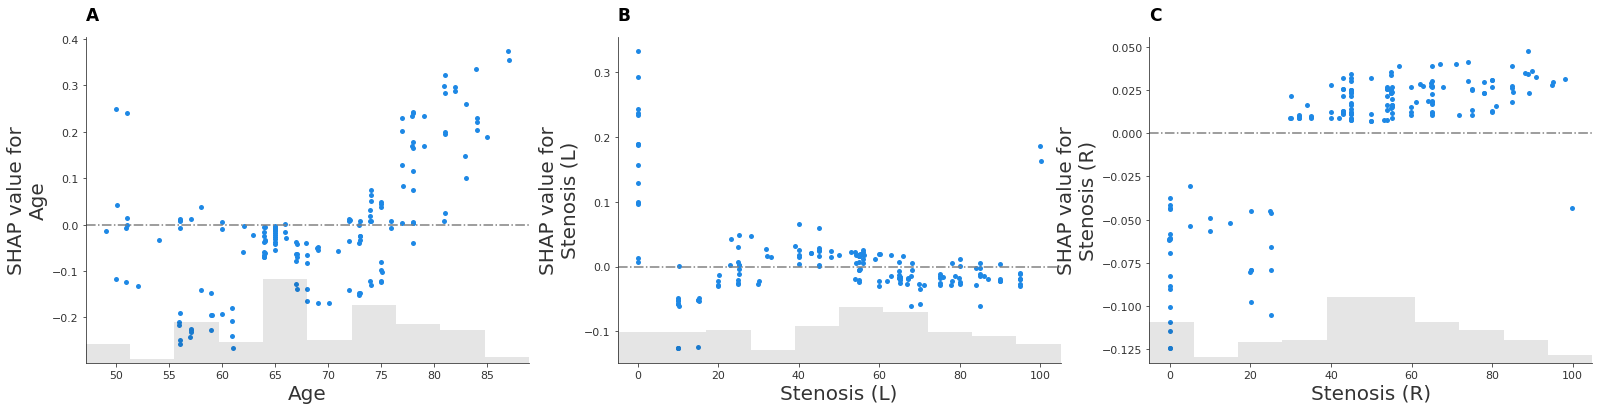

In [42]:
np.random.seed(1303)
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(27, 6))
#shap.plots.scatter(sh[:, "IPH to lipid volume ratio"],
#                  color=sh[:, "Lipid volume"],
#                  ax=ax[0], show=False,
#                  cmap=custom_cmap,
#                  dot_size=20,
#                  x_jitter=0.2)
shap.plots.scatter(sh[:, sh.abs.mean(0).argsort[-5]],
                  #color=sh[:, "Hyperlipidemia"],
                  ax=ax[0], show=False,
                  cmap=custom_cmap,
                  dot_size=25,
                  x_jitter=0.1)
shap.plots.scatter(sh[:, sh.abs.mean(0).argsort[-9]],
                  #color=sh[:, "Male"],
                  ax=ax[1], show=False,
                  cmap=custom_cmap,
                  dot_size=25,
                  x_jitter=0.2)

shap.plots.scatter(sh[:, sh.abs.mean(0).argsort[-11]],
                  #color=sh[:, "Male"],
                  ax=ax[2], show=False,
                  cmap=custom_cmap,
                  dot_size=25,
                  x_jitter=0.2)
#labels = ax.get_xticklabels()
#labels = [''] + list(calc_map.values()) + ['']
#ax.set_xticklabels(labels)
#plt.xticks(rotation=90)

ax[0].xaxis.label.set_size(20)
ax[0].yaxis.label.set_size(20)

ax[1].xaxis.label.set_size(20)
ax[1].yaxis.label.set_size(20)

ax[2].xaxis.label.set_size(20)
ax[2].yaxis.label.set_size(20)

ax[0].axhline(y=0, color='gray', linestyle='-.')
ax[1].axhline(y=0, color='gray', linestyle='-.')
ax[2].axhline(y=0, color='gray', linestyle='-.')

ax[0].text(0, 1.05, "A", transform=ax[0].transAxes, size=17, weight='bold')
ax[1].text(0, 1.05, "B", transform=ax[1].transAxes, size=17, weight='bold')
ax[2].text(0, 1.05, "C", transform=ax[2].transAxes, size=17, weight='bold')

plt.savefig("../output/plots/TIFF/dependency_age_stenosis_left.tiff", dpi=1200, format="tiff", 
            bbox_inches='tight', pil_kwargs={"compression": "tiff_lzw"})
plt.show()

# Accumulated Local Effects

# PyMint

In [56]:
import pymint

In [183]:
train_ns = pd.read_csv("../input/train.csv")
X_train_ns, y_train_ns = train_ns.drop('symptoms', axis=1), train_ns['symptoms']

In [184]:
estimators = [("LGBM", model)]

In [66]:
#cat = X_train_ns.select_dtypes(include="object").columns.tolist()
#X_train_ns[cat] = X_train_ns[cat].astype("category")

In [185]:
le = LabelEncoder()
oe = OrdinalEncoder()

to_encode = ["TIA", "hypertension", "cad", "gender",
             "diabetes", "hyperlipidemia", "smoker_status",
             "prs_either", 
             #'prs_left', 'prs_right',
             'calc_and_lipids', 'at_least_5_and_stenosis_either',
             #'at_least_5_and_stenosis_left', 'at_least_5_and_stenosis_right'
            ]

to_ohe = ["calcification_type_left", "calcification_type_right" 
          #'stenosis_risk_left', 'stenosis_risk_right'
         ]
prefixes = ["calcification_left", "calcification_right" 
            #'stenosis_risk_left', 'stenosis_risk_right'
           ]
X_train_ns = pd.get_dummies(X_train_ns, 
                   columns=to_ohe, prefix=prefixes)

y_train_ns = le.fit_transform(y_train_ns)
X_train_ns[to_encode] = oe.fit_transform(X_train_ns[to_encode]).astype(np.uint8)

# convert uint8 dtypes to categorical
cat_cols = X_train_ns.select_dtypes(include=np.uint8).columns.tolist()
#X_train_ns[cat_cols] = X_train_ns[cat_cols].astype("category")

In [186]:
X_train_ns.drop(["site", "patient_ID", "infarct_side", "stroke"], axis=1, inplace=True)

In [94]:
#X_train_ns = X_train_ns.astype(np.float64)

## Accumulated Local Effects

In [190]:
explainer = pymint.InterpretToolkit(estimators, 
                                    X=X_train_ns, 
                                    y=y_train_ns)

ale_1d_ds = explainer.ale(features='all',
                          n_bootstrap=1000, 
                          n_jobs=8, 
                          n_bins=6)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

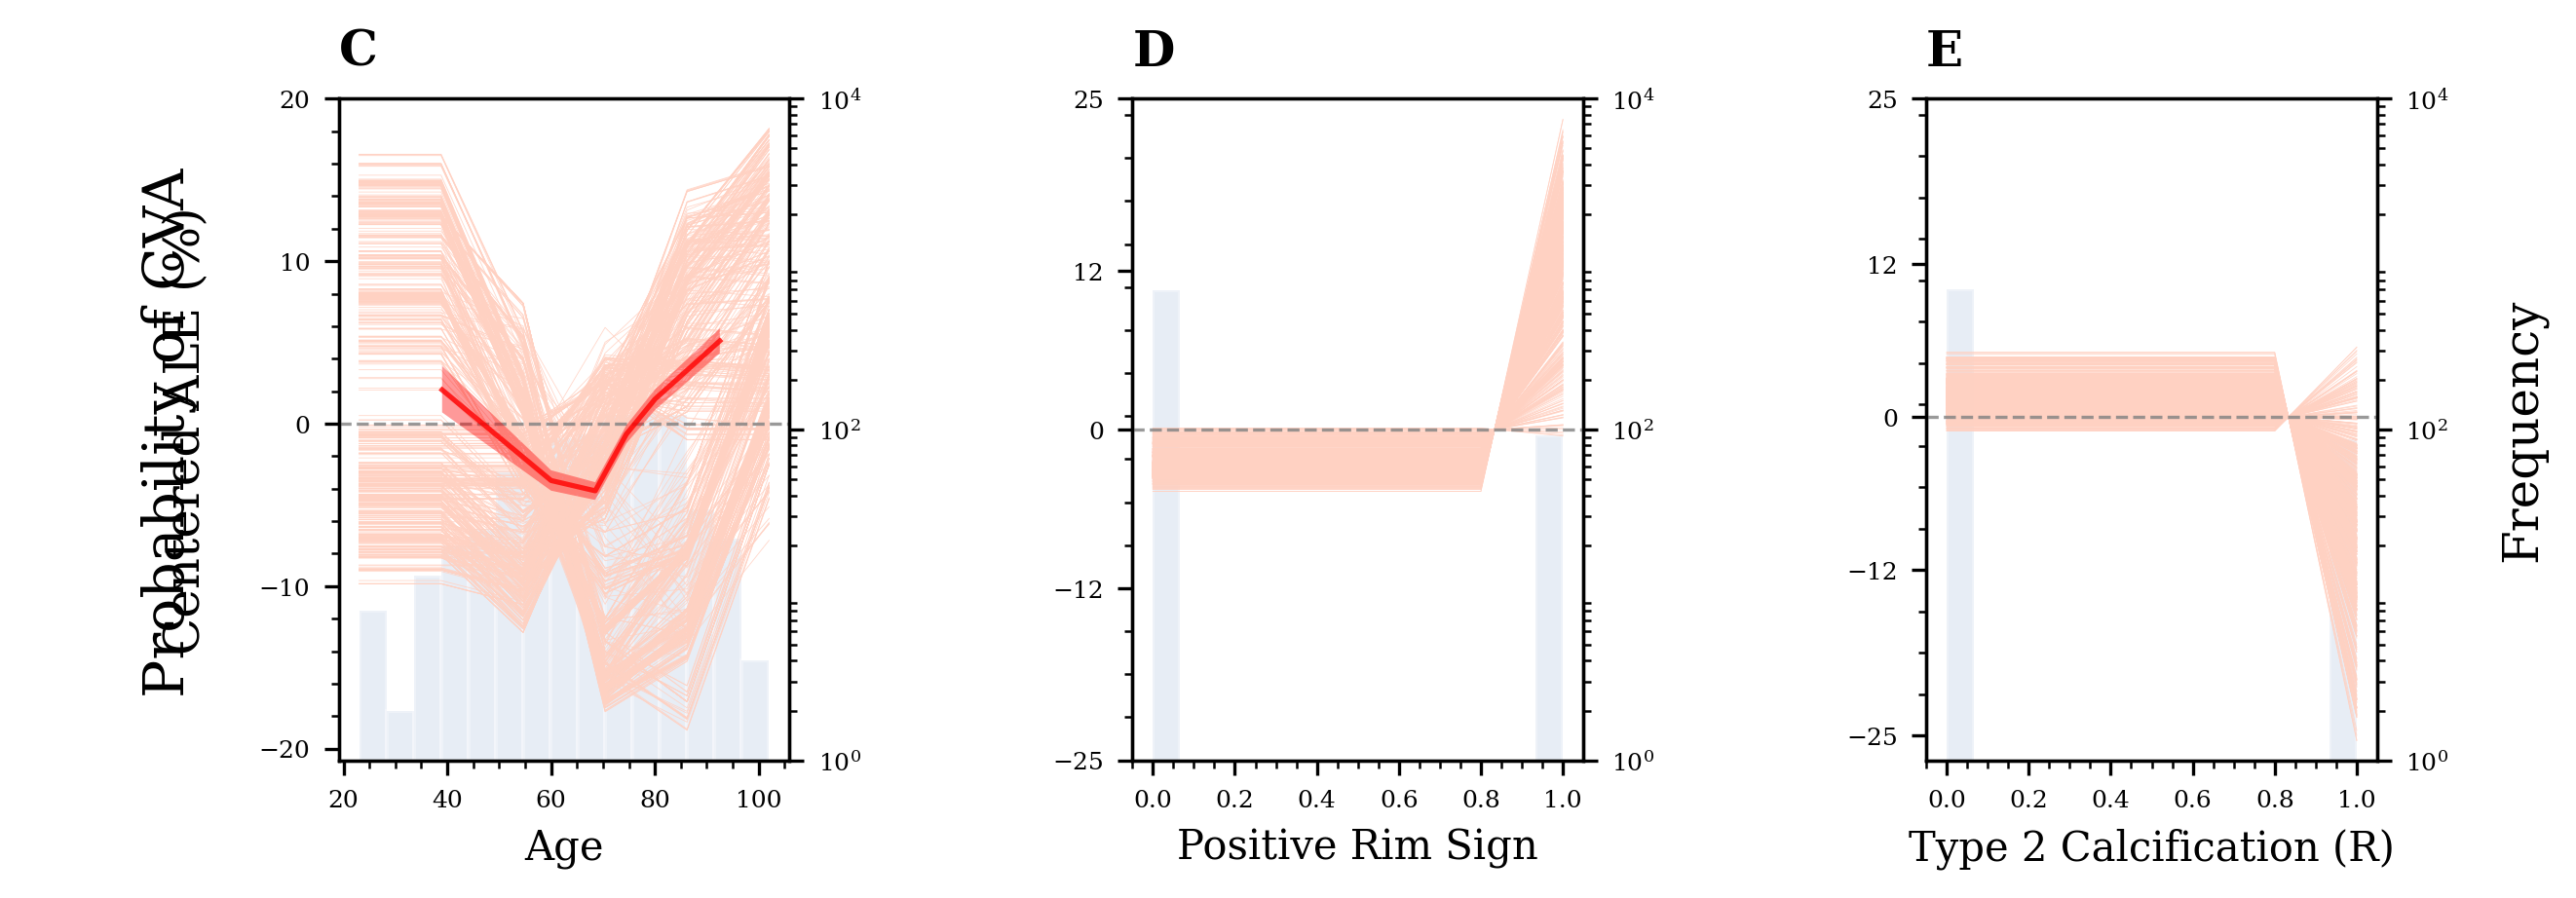

In [100]:
n = 3
top_n_idxs = np.flip(sh.abs.mean(0).argsort[-n:].values)
top_n_feats = X_train_ns.columns[top_n_idxs]

ice_ds = explainer.ice( features=top_n_feats, n_jobs=4, n_bins=6)

f, axes = explainer.plot_ale(ale = ale_1d_ds, 
                             features=top_n_feats,
                             display_feature_names=columns_map,
                             figsize=(9, 3),
                             ice_curves=ice_ds,
                             #fontsize=16,
                             #color_by=["perc_iph", "perc_iph", "perc_lipid"],
                             to_probability=True,
                             cmap=custom_cmap,
                             hist_color = lightblue)
axes[0].set_xlabel('Age', fontsize=10)
axes[1].set_xlabel('Positive Rim Sign', fontsize=10)
axes[2].set_xlabel('Type 2 Calcification (R)', fontsize=10)


#f.suptitle("Effect on prediction of relevant features", x=0.5, y=1.05, fontsize=15, weight="normal")

rect3 = matplotlib.patches.Rectangle((20, 40),
                                     17, 200,
                                     color ='white')
f.patches.extend([rect3])
#axes[0].set_xlim(-3,3)
#axes[0].set_ylim(-3,3)

f.supylabel('Probability of CVA', x = 0.05)

for ax in axes:
    for i, line in enumerate(ax.get_lines()):
        lab = line.get_label()
        
        if lab == "LGBM":
            line.set_color("red")
        else:
            line.set_color(lightsalmon)
            line.set_zorder(-200)  # put the legend on top

    ax.get_lines()[-1].set_color("gray")
    
    for child in ax.get_children():
        if isinstance(child, matplotlib.text.Text):
            if child.get_text() in ["(a)", "(b)", "(c)"]:
                child.set_text("")

axes[0].text(0, 1.05, "C", transform=axes[0].transAxes, size=12, weight='bold')
axes[1].text(0, 1.05, "D", transform=axes[1].transAxes, size=12, weight='bold')
axes[2].text(0, 1.05, "E", transform=axes[2].transAxes, size=12, weight='bold')

f.savefig("../output/plots/ALE.pdf", dpi=400, bbox_inches='tight')

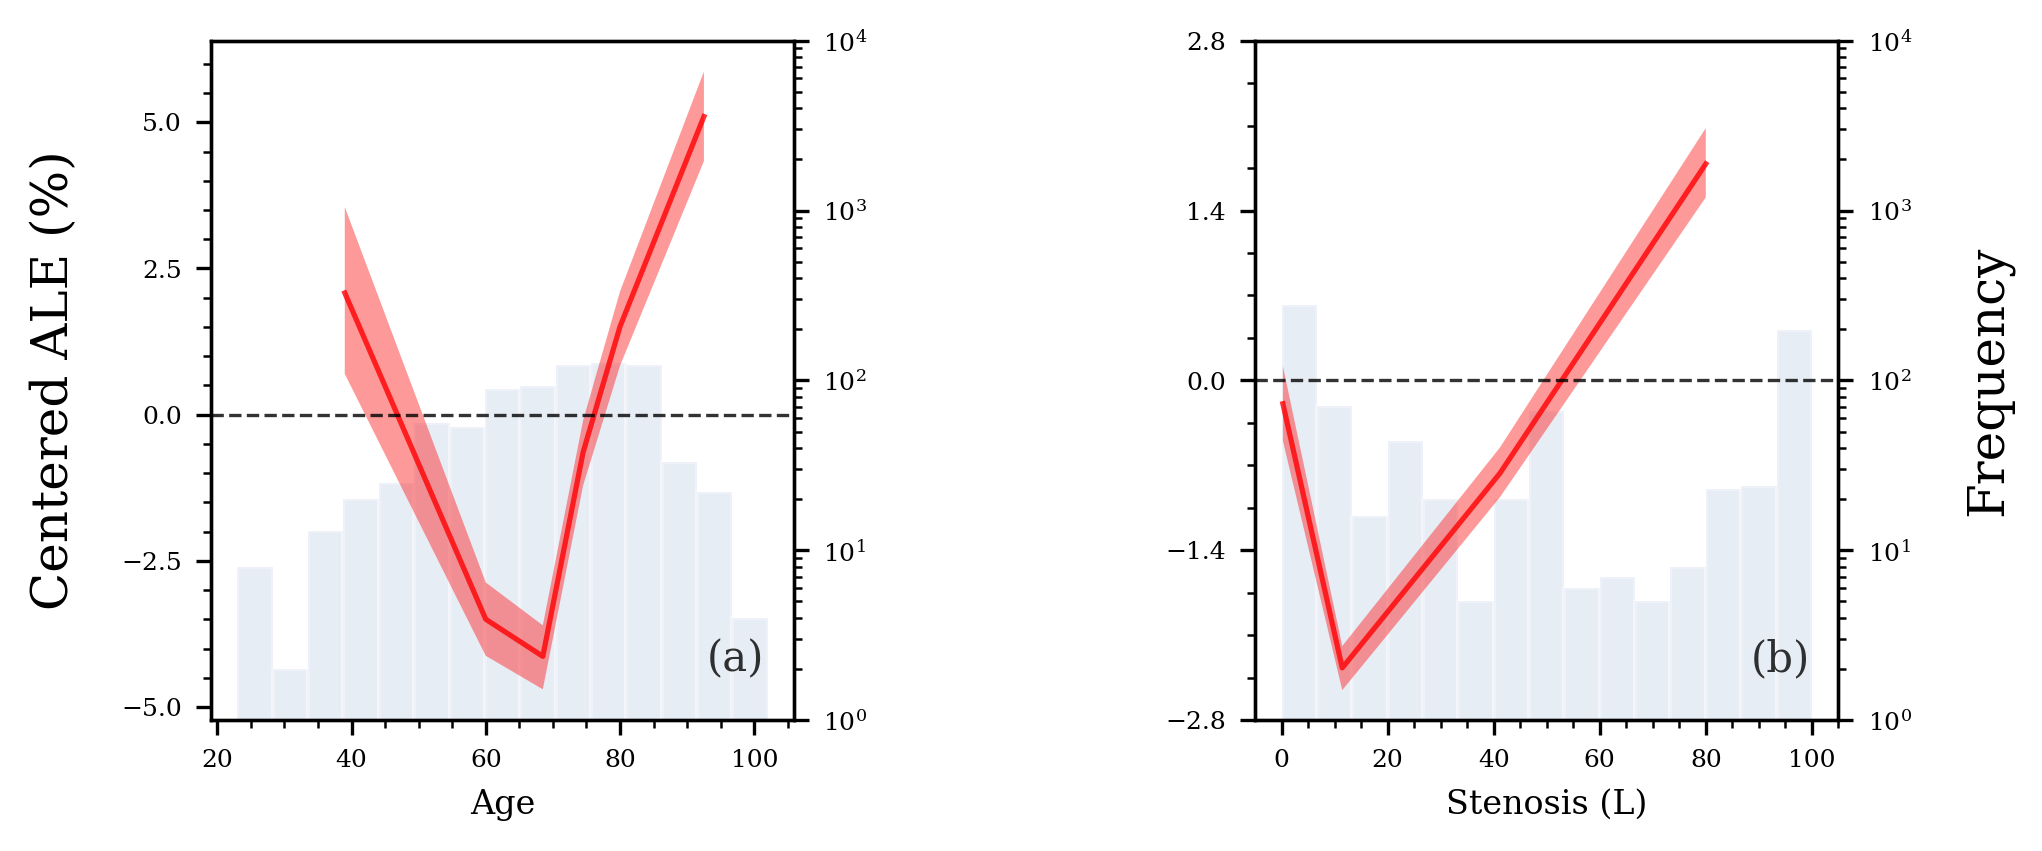

In [116]:
f, axes = explainer.plot_ale(ale = ale_1d_ds, 
                             features=["age", "stenosis_left"],
                             display_feature_names=columns_map,
                             figsize=(7, 3),
                             #ice_curves=ice_ds,
                             #fontsize=16,
                             #color_by=["perc_iph", "perc_iph", "perc_lipid"],
                             to_probability=False,
                             cmap=custom_cmap,
                             hist_color = lightblue)

In [120]:
X_train_ns_copy = X_train_ns.copy()

In [133]:
#X_train_ns_copy["prs_either"] = X_train_ns_copy["prs_either"].astype("category")
X_train_ns_copy["prs_either"] = X_train_ns_copy["prs_either"].astype("float64")

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

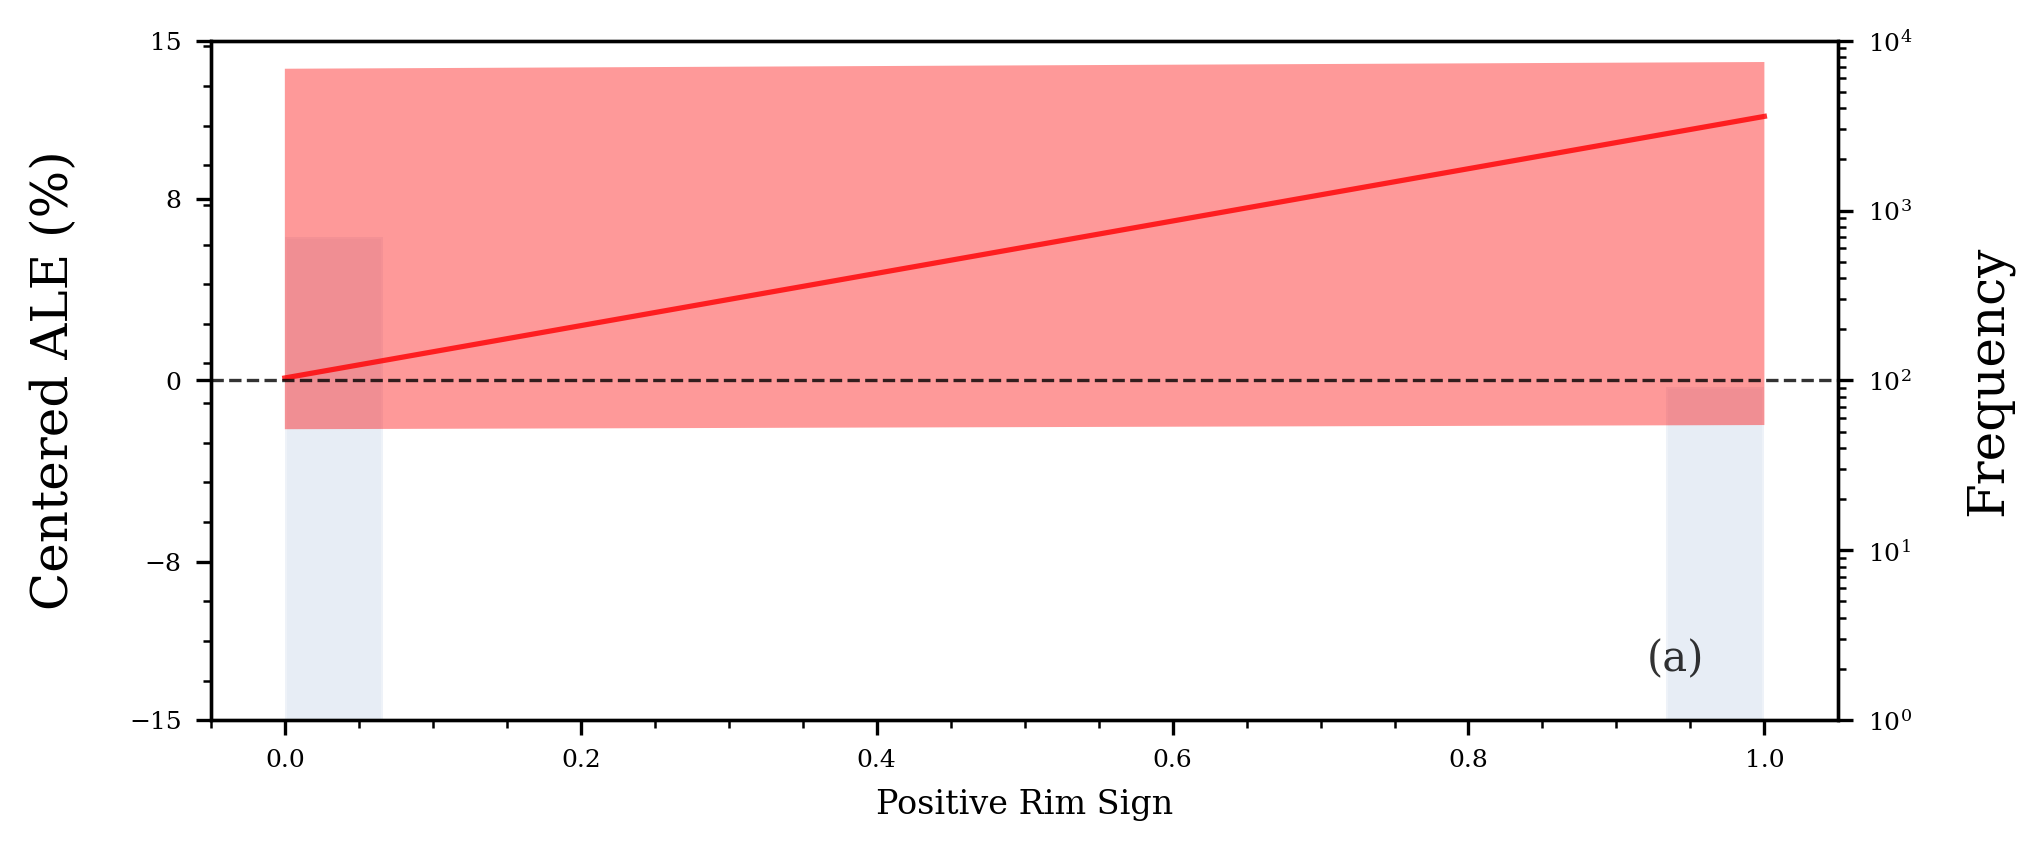

In [124]:
explainer = pymint.InterpretToolkit(estimators, 
                                    X=X_train_ns_copy, 
                                    y=y_train_ns)

ale_1d_ds = explainer.ale(features='all',
                          n_bootstrap=1000, 
                          n_jobs=8, 
                          n_bins=6)

# Decision plots
Focusing on misclassifications

In [43]:
# load predicted probabilities of positive class
#probas = pd.read_csv("../output/predictions/external_test_preds_LGBM_tuned_merged_10outer_100.csv")
probas = pd.read_csv("../output/predictions/test_preds_tuned_LGBM_all_features_0035_70trials.csv")
pos_class_proba = probas["proba"]

In [44]:
y_test_ns_raw = pd.Series(y_test)

In [45]:
threshold = 0.4853442
#threshold = 0.5729885
labels = np.where(pos_class_proba >= threshold, 1, 0)
#fn_mask = (pos_class_proba < threshold) & (y_test_ns_raw == 1)
#fp_mask = (pos_class_proba >= threshold) & (y_test_ns_raw == 0)
#tp_mask = (pos_class_proba >= threshold) & (y_test_ns_raw == 1)
#tn_mask = (pos_class_proba < threshold) & (y_test_ns_raw == 0)
fn_mask = (labels == 0) & (y_test_ns_raw == 1)
fp_mask = (labels == 1) & (y_test_ns_raw == 0)
tp_mask = (labels == 1) & (y_test_ns_raw == 1)
tn_mask = (labels == 0) & (y_test_ns_raw == 0)

In [91]:
# index of false negatives
print("Indices of false negatives: ", list(fn_mask[fn_mask == True].index))
print("Indices of false positives: ", list(fp_mask[fp_mask == True].index))

Indices of false negatives:  [97, 102, 103, 105, 118, 120, 123, 126, 127, 128, 129, 135, 141, 145, 146, 147, 148, 149, 150, 156, 157, 158]
Indices of false positives:  [6, 8, 10, 13, 15, 20, 23, 29, 33, 34, 38, 40, 53, 55, 57, 58, 60, 71, 77, 81, 85, 88, 90, 92, 94]


In [47]:
# Visualize predicted probabilities of false negatives along with index
print("False negatives")
false_negatives = list(zip(fn_mask[fn_mask == True].index, pos_class_proba[fn_mask]))
sorted(false_negatives, key=lambda tup: tup[1], reverse=True)

False negatives


[(158, 0.4448940075544773),
 (97, 0.4337138345546311),
 (156, 0.4206689657370739),
 (157, 0.3985161285213275),
 (128, 0.3857780450632415),
 (123, 0.3676713025740838),
 (147, 0.3588945925553184),
 (118, 0.3556838383079805),
 (135, 0.3478268348178433),
 (102, 0.3404065924146247),
 (141, 0.3346036019345879),
 (150, 0.3307446998745407),
 (120, 0.2988835772676875),
 (103, 0.2973191736013864),
 (148, 0.2953737766108649),
 (145, 0.2936832498816588),
 (105, 0.2909573717332737),
 (127, 0.2823809928195412),
 (146, 0.2665584836162494),
 (129, 0.2658935543970454),
 (149, 0.2470072120859256),
 (126, 0.2455516547037053)]

In [48]:
# Visualize predicted probabilities of false negatives along with index
print("False positives")
false_positives = zip(fp_mask[fp_mask == True].index, pos_class_proba[fp_mask])
sorted(false_positives, key=lambda tup: tup[1], reverse=True)

False positives


[(8, 0.8155170254871693),
 (85, 0.7477572273316015),
 (20, 0.7326998803527525),
 (10, 0.6970925200541762),
 (38, 0.6965602490900467),
 (60, 0.6937335506396639),
 (90, 0.6810289109482108),
 (34, 0.6764188658605123),
 (94, 0.6689191546710931),
 (33, 0.6673739443470249),
 (58, 0.6609184146565144),
 (92, 0.6569742514137282),
 (55, 0.6113675293216251),
 (57, 0.599277849204048),
 (81, 0.5932999804207969),
 (13, 0.593118281589276),
 (77, 0.5765569839185001),
 (40, 0.5708907550896112),
 (53, 0.5684750714450413),
 (23, 0.5574511977287406),
 (15, 0.5525480612361782),
 (6, 0.5369376772371611),
 (29, 0.5259164279532149),
 (71, 0.4974105409430628),
 (88, 0.4957330928844004)]

In [54]:
fn_idx = 126
fp_idx = 8

In [178]:
# Visualize features of a false negative
print(X_test_renamed.iloc[fn_idx])
print("Symptoms: ", y_test[fn_idx])

TIA                                  0.0
Hypertension                         1.0
CAD                                  1.0
Smoker                               1.0
Age                                 69.0
Male                                 0.0
Diabetes                             0.0
Hyperlipidemia                       0.0
Stenosis (R)                        55.0
Stenosis (L)                        78.0
Positive Rim Sign                    0.0
Calcification and Hyperlipidemia     0.0
Type 5/6 and > 70% Stenosis          0.0
Type 1 Calcification (L)             1.0
Type 2 Calcification (L)             0.0
Type 3 Calcification (L)             0.0
Type 4 Calcification (L)             0.0
Type 5 Calcification (L)             0.0
Type 6 Calcification (L)             0.0
Type 1 Calcification (R)             1.0
Type 2 Calcification (R)             0.0
Type 3 Calcification (R)             0.0
Type 4 Calcification (R)             0.0
Type 5 Calcification (R)             0.0
Type 6 Calcifica

In [179]:
# Visualize features of a false negative
print(X_test_renamed.iloc[fp_idx])
print("Symptoms: ", y_test_ns_raw[fp_idx])

TIA                                  0.0
Hypertension                         0.0
CAD                                  0.0
Smoker                               1.0
Age                                 81.0
Male                                 0.0
Diabetes                             1.0
Hyperlipidemia                       1.0
Stenosis (R)                        20.0
Stenosis (L)                        10.0
Positive Rim Sign                    1.0
Calcification and Hyperlipidemia     1.0
Type 5/6 and > 70% Stenosis          0.0
Type 1 Calcification (L)             0.0
Type 2 Calcification (L)             0.0
Type 3 Calcification (L)             0.0
Type 4 Calcification (L)             1.0
Type 5 Calcification (L)             0.0
Type 6 Calcification (L)             0.0
Type 1 Calcification (R)             0.0
Type 2 Calcification (R)             0.0
Type 3 Calcification (R)             0.0
Type 4 Calcification (R)             0.0
Type 5 Calcification (R)             0.0
Type 6 Calcifica

In [180]:
[f"{idx}: {col}" for idx, col in enumerate(X_test_renamed.columns)]
# 1, 0, 11, 9, 7, 10, 5, 8, 4, 3, 6, 2

['0: TIA',
 '1: Hypertension',
 '2: CAD',
 '3: Smoker',
 '4: Age',
 '5: Male',
 '6: Diabetes',
 '7: Hyperlipidemia',
 '8: Stenosis (R)',
 '9: Stenosis (L)',
 '10: Positive Rim Sign',
 '11: Calcification and Hyperlipidemia',
 '12: Type 5/6 and > 70% Stenosis',
 '13: Type 1 Calcification (L)',
 '14: Type 2 Calcification (L)',
 '15: Type 3 Calcification (L)',
 '16: Type 4 Calcification (L)',
 '17: Type 5 Calcification (L)',
 '18: Type 6 Calcification (L)',
 '19: Type 1 Calcification (R)',
 '20: Type 2 Calcification (R)',
 '21: Type 3 Calcification (R)',
 '22: Type 4 Calcification (R)',
 '23: Type 5 Calcification (R)',
 '24: Type 6 Calcification (R)']

In [49]:
feat_idx_sorted = np.flip(sh.abs.mean(0).argsort.values)
col_names_sorted = X_test_renamed.columns[feat_idx_sorted]

In [50]:
def is_number(n):
    try:
        float(n)   # Type-casting the string to `float`.
                   # If string is not a valid `float`, 
                   # it'll raise `ValueError` exception
    except ValueError:
        return False
    return True

## New and correct

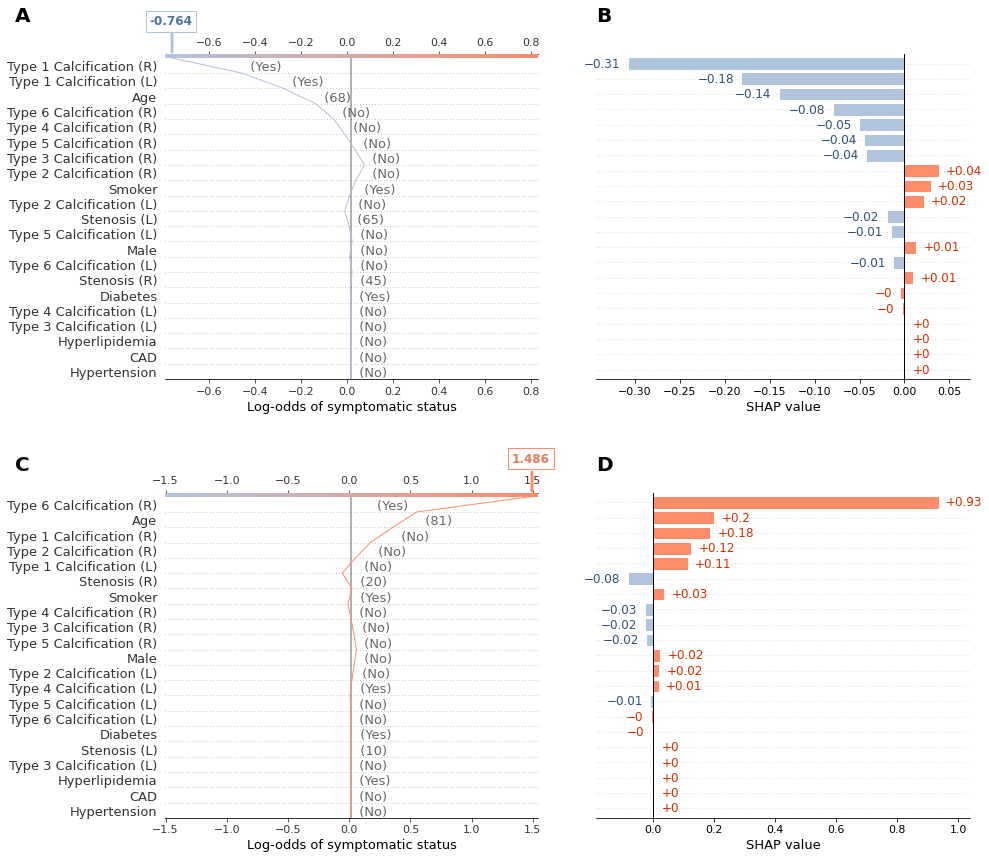

In [61]:
feature_order = list(reversed(feat_idx_sorted))


fig = plt.figure(figsize=(14, 600))

### First figure start ###
fst_ax1 = fig.add_subplot(221)
shap.decision_plot(expected_value, 
                   sh.values[fn_idx], 
                   X_test_fancy.iloc[fn_idx],
                   feature_names=list(X_test_fancy.columns),
                   link='identity',
                   plot_color=custom_cmap,
                   feature_display_range=slice(None, -len(feature_order)-1, -1),
                   show=False, auto_size_plot=False) 
fst_ax1.text(-0.4, 1.1, "A", transform=fst_ax1.transAxes, 
    size=20, weight='bold')

model_output_logodds = sh.base_values[0] + sh.values[fn_idx].sum()
fst_ax1.text(-0.04, 1.09, "{:.3f}".format(model_output_logodds), 
             transform=fst_ax1.transAxes, 
             size=12, 
             weight='bold',
             color=blue,
             bbox=dict(facecolor='none', edgecolor=lightblue))
fst_ax1.annotate("",
             xy=(0.02, 1.00), xycoords='axes fraction',
             xytext=(0.02, 1.07), textcoords='axes fraction',
             arrowprops=dict(arrowstyle="-",
                             lw=3,
                             color=lightblue,
                             connectionstyle="arc3,rad=0."))

fst_ax1.set_xlabel("Log-odds of symptomatic status")

# reduce fontsize of feature values
#annots = [child for child in fst_ax1.get_children() if isinstance(child, matplotlib.text.Text) and child.get_text() != '']
#for annot in annots:
#    annot.set_fontsize(9)

# add waterfall
fst_ax2 = fig.add_subplot(222)
shap.plots.bar(sh[fn_idx], show=False, 
               max_display=len(feature_order)
               # - 4
              )
fst_ax2.margins(y=0.013)
fst_ax2.tick_params(axis='y', which='major', pad=25)
fst_ax2.set_yticks([])
fst_ax2.text(0, 1.1, "B", transform=fst_ax2.transAxes, size=20, weight='bold')

fst_annotations = [child for child in fst_ax2.get_children() if isinstance(child, matplotlib.text.Text)]


for i, annot in enumerate(fst_annotations):
    t = annot.get_text().replace("+", "+").replace("−","-")
    if is_number(t): #special character -
        t = float(t)
        if t >= 0:          
            fst_ax2.patches[i].set_color("#ff8c69")  
            annot.set_color("#d03000")
        else:
            fst_ax2.patches[i].set_color("#b0c4de")
            annot.set_color("#315076")

# add rectangle

### First figure end ###

# -------------------------------------------------------------

### Second figure start ###

snd_ax1 = fig.add_subplot(223)
shap.decision_plot(expected_value, 
                   sh.values[fp_idx], 
                   X_test_fancy.iloc[fp_idx],
                   feature_names=list(X_test_fancy.columns),
                   link='identity',
                   plot_color=custom_cmap,
                   feature_display_range=slice(None, -len(feature_order)-1, -1),
                   show=False, auto_size_plot=False) 
snd_ax1.text(-0.4, 1.07, "C", transform=snd_ax1.transAxes, size=20, weight='bold')

model_output_logodds = sh.base_values[0] + sh.values[fp_idx].sum()
snd_ax1.text(0.93, 1.095, "{:.3f}".format(model_output_logodds), 
             transform=snd_ax1.transAxes, 
             size=12, 
             weight='bold',
             color=darksalmon,
             bbox=dict(facecolor='none', edgecolor=salmon))
snd_ax1.annotate("",
             xy=(0.983, 1.00), xycoords='axes fraction',
             xytext=(0.983, 1.07), textcoords='axes fraction',
             arrowprops=dict(arrowstyle="-",
                             lw=3,
                             color=salmon,
                             connectionstyle="arc3,rad=0."))

snd_ax1.set_xlabel("Log-odds of symptomatic status")

# add waterfall
snd_ax2 = fig.add_subplot(224)
shap.plots.bar(sh[fp_idx], show=False, 
               max_display=len(feature_order)
              )
snd_ax2.tick_params(axis='y', which='major', pad=25)
#plt.ylabel("...", labelpad=2)
snd_ax2.set_yticks([])
snd_ax2.margins(y=0.013)
snd_ax2.text(0, 1.07, "D", transform=snd_ax2.transAxes, size=20, weight='bold')


snd_annotations = [child for child in snd_ax2.get_children() if isinstance(child, matplotlib.text.Text)] 

### Second plot

for i, annot in enumerate(snd_annotations):
    t = annot.get_text().replace("+", "+").replace("−","-")
    if is_number(t): #special character -
        t = float(t)
        if t >= 0:          
            snd_ax2.patches[i].set_color("#ff8c69")  
            annot.set_color("#d03000")
        else:
            snd_ax2.patches[i].set_color("#b0c4de")
            annot.set_color("#315076")

# arrange subplots
#plt.tight_layout(rect=[0.0, 0.0, 1.75, 1.0])
plt.tight_layout(rect=[0.0, 0.0, 1.75, 1.0])
plt.subplots_adjust(hspace=0.35)

# add second rectangle
plt.draw()
### Second figure end ###


# add general title to the plot
#fig.suptitle("Interpretation of individual predictions", x=0.9, y=1.10, fontsize=20, weight="normal")


#plt.savefig("../output/plots/misclassifications_logodds.pdf", dpi=400, bbox_inches='tight')
plt.savefig("../output/plots/TIFF/misclassifications_logodds.tiff", format="tiff", dpi=1200, bbox_inches='tight',
           pil_kwargs={"compression": "tiff_lzw"})

#plt.show()

# start from the second subplot (bottom) and then the first plot

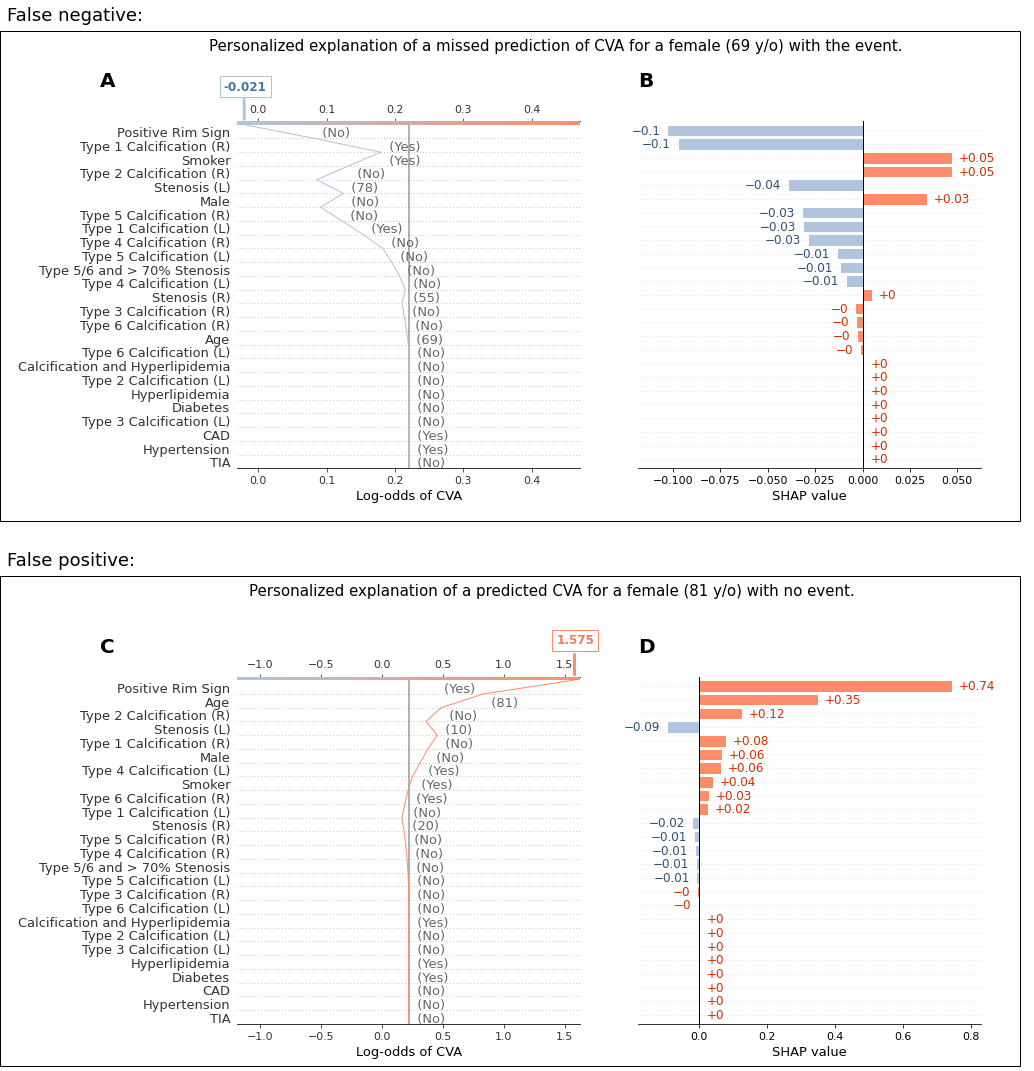

In [104]:
feature_order = list(reversed(feat_idx_sorted))


fig = plt.figure(figsize=(14, 600))

### First figure start ###
fig.text(0, 1.04, "False negative:", size=18, weight='normal')    
fig.text(s="Personalized explanation of a missed prediction of CVA for a female (69 y/o) with the event.",
            x=0.35, y=1.01, fontsize=15)

fst_ax1 = fig.add_subplot(221)
shap.decision_plot(expected_value, 
                   sh.values[fn_idx], 
                   X_test_fancy.iloc[fn_idx],
                   feature_names=list(X_test_fancy.columns),
                   link='identity',
                   plot_color=custom_cmap,
                   feature_display_range=slice(None, -len(feature_order)-1, -1),
                   show=False, auto_size_plot=False) 
fst_ax1.text(-0.4, 1.1, "A", transform=fst_ax1.transAxes, 
    size=20, weight='bold')

model_output_logodds = sh.base_values[0] + sh.values[fn_idx].sum()
fst_ax1.text(-0.04, 1.09, "{:.3f}".format(model_output_logodds), 
             transform=fst_ax1.transAxes, 
             size=12, 
             weight='bold',
             color=blue,
             bbox=dict(facecolor='none', edgecolor=lightblue))
fst_ax1.annotate("",
             xy=(0.02, 1.00), xycoords='axes fraction',
             xytext=(0.02, 1.07), textcoords='axes fraction',
             arrowprops=dict(arrowstyle="-",
                             lw=3,
                             color=lightblue,
                             connectionstyle="arc3,rad=0."))

fst_ax1.set_xlabel("Log-odds of CVA")

# reduce fontsize of feature values
#annots = [child for child in fst_ax1.get_children() if isinstance(child, matplotlib.text.Text) and child.get_text() != '']
#for annot in annots:
#    annot.set_fontsize(9)

# add waterfall
fst_ax2 = fig.add_subplot(222)
shap.plots.bar(sh[fn_idx], show=False, 
               max_display=len(feature_order)
               # - 4
              )
fst_ax2.margins(y=0.013)
fst_ax2.tick_params(axis='y', which='major', pad=25)
fst_ax2.set_yticks([])
fst_ax2.text(0, 1.1, "B", transform=fst_ax2.transAxes, size=20, weight='bold')

fst_annotations = [child for child in fst_ax2.get_children() if isinstance(child, matplotlib.text.Text)]


for i, annot in enumerate(fst_annotations):
    t = annot.get_text().replace("+", "+").replace("−","-")
    if is_number(t): #special character -
        t = float(t)
        if t >= 0:          
            fst_ax2.patches[i].set_color("#ff8c69")  
            annot.set_color("#d03000")
        else:
            fst_ax2.patches[i].set_color("#b0c4de")
            annot.set_color("#315076")

# add rectangle
rect = plt.Rectangle((0, 550), 1020, 490, linewidth=1, edgecolor='black', facecolor='none') #550, 530
fig.patches.extend([rect])

### First figure end ###

# -------------------------------------------------------------

### Second figure start ###
fig.text(0, 0.5, "False positive:", size=18, weight='normal')  
fig.text(s="Personalized explanation of a predicted CVA for a female (81 y/o) with no event.",
            x=0.42, y=0.47, fontsize=15)

snd_ax1 = fig.add_subplot(223)
shap.decision_plot(expected_value, 
                   sh.values[fp_idx], 
                   X_test_fancy.iloc[fp_idx],
                   feature_names=list(X_test_fancy.columns),
                   link='identity',
                   plot_color=custom_cmap,
                   feature_display_range=slice(None, -len(feature_order)-1, -1),
                   show=False, auto_size_plot=False) 
snd_ax1.text(-0.4, 1.07, "C", transform=snd_ax1.transAxes, size=20, weight='bold')

model_output_logodds = sh.base_values[0] + sh.values[fp_idx].sum()
snd_ax1.text(0.93, 1.095, "{:.3f}".format(model_output_logodds), 
             transform=snd_ax1.transAxes, 
             size=12, 
             weight='bold',
             color=darksalmon,
             bbox=dict(facecolor='none', edgecolor=salmon))
snd_ax1.annotate("",
             xy=(0.983, 1.00), xycoords='axes fraction',
             xytext=(0.983, 1.07), textcoords='axes fraction',
             arrowprops=dict(arrowstyle="-",
                             lw=3,
                             color=salmon,
                             connectionstyle="arc3,rad=0."))

snd_ax1.set_xlabel("Log-odds of CVA")

# add waterfall
snd_ax2 = fig.add_subplot(224)
shap.plots.bar(sh[fp_idx], show=False, 
               max_display=len(feature_order)
              )
snd_ax2.tick_params(axis='y', which='major', pad=25)
#plt.ylabel("...", labelpad=2)
snd_ax2.set_yticks([])
snd_ax2.margins(y=0.013)
snd_ax2.text(0, 1.07, "D", transform=snd_ax2.transAxes, size=20, weight='bold')


snd_annotations = [child for child in snd_ax2.get_children() if isinstance(child, matplotlib.text.Text)] 

### Second plot

for i, annot in enumerate(snd_annotations):
    t = annot.get_text().replace("+", "+").replace("−","-")
    if is_number(t): #special character -
        t = float(t)
        if t >= 0:          
            snd_ax2.patches[i].set_color("#ff8c69")  
            annot.set_color("#d03000")
        else:
            snd_ax2.patches[i].set_color("#b0c4de")
            annot.set_color("#315076")

# arrange subplots
#plt.tight_layout(rect=[0.0, 0.0, 1.75, 1.0])
plt.tight_layout(rect=[0.0, 0.0, 1.75, 1.0])
plt.subplots_adjust(hspace=0.6)

# add second rectangle
rect = plt.Rectangle((0, 5), 1020, 490, linewidth=1, edgecolor='black', facecolor='none')
fig.patches.extend([rect])
plt.draw()
### Second figure end ###


# add general title to the plot
#fig.suptitle("Interpretation of individual predictions", x=0.9, y=1.10, fontsize=20, weight="normal")


#plt.savefig("../output/plots/misclassifications_logodds.pdf", dpi=400, bbox_inches='tight')
plt.savefig("../output/plots/misclassifications_logodds.tiff", format="tiff", dpi=fig.dpi, bbox_inches='tight')

#plt.show()

# start from the second subplot (bottom) and then the first plot

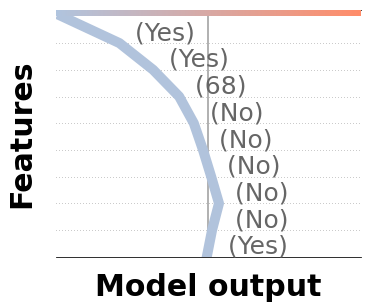

In [62]:
feature_order = list(reversed(feat_idx_sorted))


fig = plt.figure(figsize=(12, 10))

ax1 = fig.add_subplot(221)
shap.decision_plot(expected_value, 
                   sh.values[fn_idx], 
                   X_test_fancy.iloc[fn_idx],
                   feature_names=list(X_test_fancy.columns),
                   link='identity',
                   plot_color=custom_cmap,
                   feature_display_range=slice(None, -10, -1),
                   show=False, auto_size_plot=False) 

#for i, line in enumerate(fst_ax1.lines):
#    if i % 2 == 0:       
#    line.set_linewidth(3)

ax1.lines[-1].set_linewidth(10)
ax1.axes.get_xaxis().set_ticks([])
ax1.axes.get_yaxis().set_ticks([])
ax1.set_xlabel("Model output", fontdict={"weight": "bold", "size": 30}, labelpad=15)
ax1.set_ylabel("Features", fontdict={"weight": "bold", "size": 30}, labelpad=20)

for child in ax1.get_children():
    if isinstance(child, matplotlib.text.Text):
        child.set_fontsize(25)
        

plt.savefig("../output/plots/TIFF/misclassifications_workflow.tiff", format="tiff", dpi=fig.dpi, bbox_inches='tight')

In [192]:
slice(None, -len(feature_order)-1, -1)

slice(None, -26, -1)

# Statistics of errors/miclassifications
Divided by false positives and false negatives

# Concat test results for all subsets

In [85]:
test_res_all_features = pd.read_csv("../output/results/test_results_tuned_LGBM_all_features_0035_70trials_youden.csv",
                                   index_col=0)
test_res_all_features = test_res_all_features.rename(columns={"test": "Clinical + Calcification data"})

test_res_only_clinical = pd.read_csv("../output/results/test_results_tuned_LGBM_only_clinical_0035_70trials.csv",
                                    index_col=0)
test_res_only_clinical = test_res_only_clinical.rename(columns={"test": "Clinical data only"})

test_res_only_calcification = pd.read_csv("../output/results/test_results_tuned_LGBM_only_calcification_0035_70trials.csv",
                                         index_col=0)
test_res_only_calcification = test_res_only_calcification.rename(columns={"test": "Calcification data only"})

In [87]:
all_results = pd.concat([test_res_all_features, test_res_only_clinical, test_res_only_calcification], axis=1)

In [89]:
all_results.to_csv("../output/results/test_results_all_subsets.csv")

# Calibration

In [218]:
from sklearn.calibration import calibration_curve
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

bin 1: 0.0 - 0.1
bin 2: 0.1 - 0.2
bin 3: 0.2 - 0.30000000000000004
bin 4: 0.30000000000000004 - 0.4
bin 5: 0.4 - 0.5
bin 6: 0.5 - 0.6000000000000001
bin 7: 0.6000000000000001 - 0.7000000000000001
bin 8: 0.7000000000000001 - 0.8
bin 9: 0.8 - 0.9
bin 10: 0.9 - 1.0


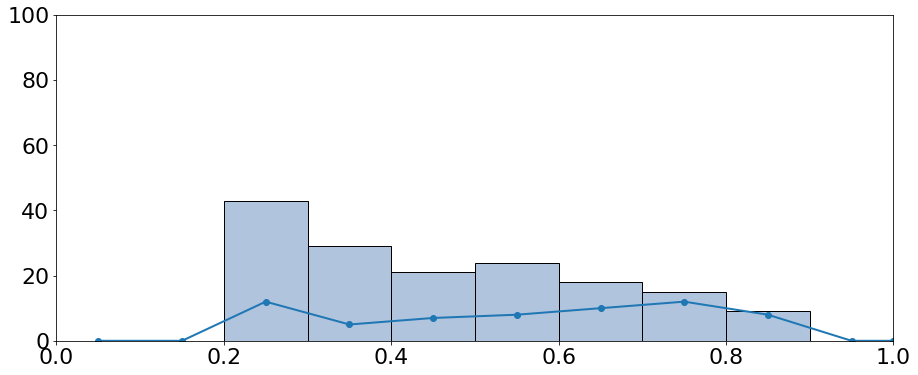

In [411]:
def calibration_plot(observed, predicted, n_bins, ax = None):
    if not ax:
        f, ax = plt.subplots(1, 1, figsize=(15, 6))
    
    bins = np.linspace(0, 1, n_bins+1)
    counts = np.zeros_like(bins)
    preds_count = np.zeros_like(bins)
    for i in range(len(bins)-1):
        print(f"bin {i+1}: {bins[i]} - {bins[i+1]}")
        mask = ((predicted >= bins[i]) & (predicted < bins[i+1]))
        counts[i] = observed[mask].sum()
        preds_count[i] = predicted[mask].shape[0]

    ax.bar(bins, preds_count, align="edge", width=0.1, color=lightblue, edgecolor="black")
    ax.plot([(bins[i] + bins[i+1]) / 2 for i in range(len(bins)-1)]+[1], counts, linewidth=2, marker='o')
    ax.set_xlim(0.0, 1.0)
    ax.set_ylim(0, 100)
    #plt.xticks(np.arange(0, 1.1, 0.1))
    #ax.set_xticklabels(range(0, 110, 10))
        
calibration_plot(probas["target"], probas["proba"], n_bins=10)

In [393]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
X, y = load_breast_cancer(return_X_y=True, as_frame=True)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, stratify=y, random_state=1234)


In [398]:
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

In [399]:
clf = LGBMClassifier(random_state=1234)
rf = RandomForestClassifier(random_state=1234)
clf.fit(Xtrain, ytrain)
rf.fit(Xtrain, ytrain)

RandomForestClassifier(random_state=1234)

In [400]:
test_probas = clf.predict_proba(Xtest)[:, 1]
test_probas_rf = rf.predict_proba(Xtest)[:, 1]

In [403]:
# try calibrate the RF model
from sklearn.calibration import CalibratedClassifierCV

In [405]:
rf_calib = CalibratedClassifierCV(rf, cv=10, method="isotonic", n_jobs=1)
rf_calib.fit(Xtrain, ytrain)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(random_state=1234),
                       cv=10, method='isotonic', n_jobs=1)

In [406]:
test_probas_rf_calib = rf_calib.predict_proba(Xtest)[:, 1]

bin 1: 0.0 - 0.1
bin 2: 0.1 - 0.2
bin 3: 0.2 - 0.30000000000000004
bin 4: 0.30000000000000004 - 0.4
bin 5: 0.4 - 0.5
bin 6: 0.5 - 0.6000000000000001
bin 7: 0.6000000000000001 - 0.7000000000000001
bin 8: 0.7000000000000001 - 0.8
bin 9: 0.8 - 0.9
bin 10: 0.9 - 1.0


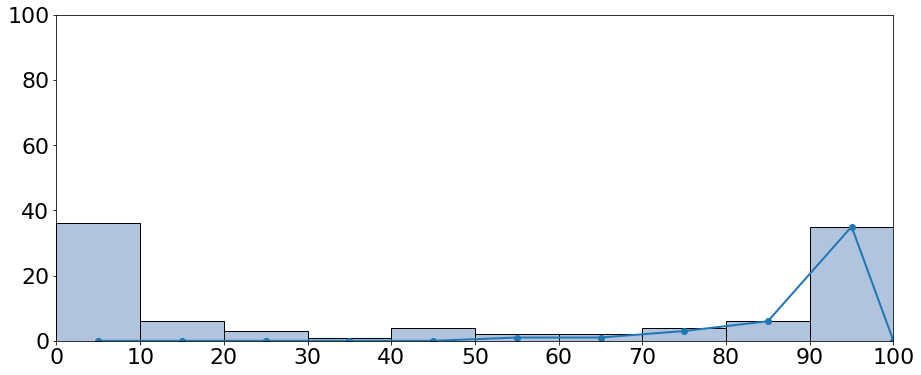

In [401]:
calibration_plot(ytest, test_probas_rf, n_bins=10)

bin 1: 0.0 - 0.05
bin 2: 0.05 - 0.1
bin 3: 0.1 - 0.15000000000000002
bin 4: 0.15000000000000002 - 0.2
bin 5: 0.2 - 0.25
bin 6: 0.25 - 0.30000000000000004
bin 7: 0.30000000000000004 - 0.35000000000000003
bin 8: 0.35000000000000003 - 0.4
bin 9: 0.4 - 0.45
bin 10: 0.45 - 0.5
bin 11: 0.5 - 0.55
bin 12: 0.55 - 0.6000000000000001
bin 13: 0.6000000000000001 - 0.65
bin 14: 0.65 - 0.7000000000000001
bin 15: 0.7000000000000001 - 0.75
bin 16: 0.75 - 0.8
bin 17: 0.8 - 0.8500000000000001
bin 18: 0.8500000000000001 - 0.9
bin 19: 0.9 - 0.9500000000000001
bin 20: 0.9500000000000001 - 1.0


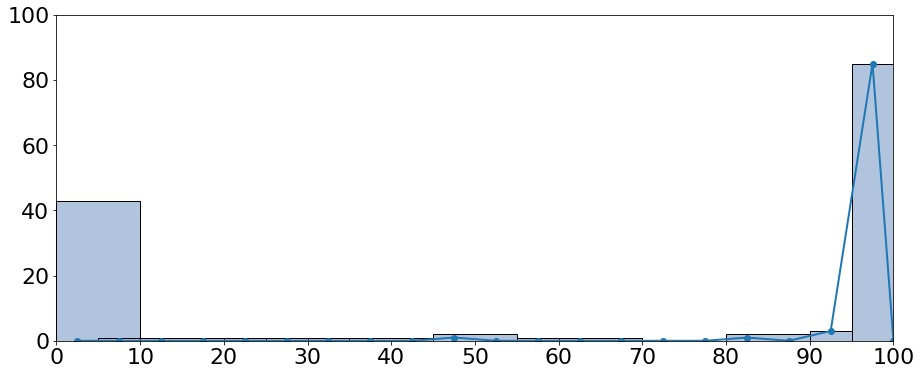

In [408]:
calibration_plot(ytest, test_probas_rf_calib, n_bins=20)

In [219]:
probas = pd.read_csv("../output/predictions/test_preds_tuned_LGBM_new_features_final.csv")
pos_class_proba = probas["proba"]

In [230]:
bin_0_10 = ((probas["proba"] >= 0.0) & probas["proba"] < 0.1)
bin_10_20 = ((probas["proba"] >= 0.1) & probas["proba"] < 0.2)
bin_20_30 = ((probas["proba"] >= 0.2) & probas["proba"] < 0.3)
bin_30_40 = ((probas["proba"] >= 0.3) & probas["proba"] < 0.4)
bin_40_50 = ((probas["proba"] >= 0.4) & probas["proba"] < 0.5)
bin_50_60 = ((probas["proba"] >= 0.5) & probas["proba"] < 0.6)
bin_60_70 = ((probas["proba"] >= 0.6) & probas["proba"] < 0.7)
bin_70_80 = ((probas["proba"] >= 0.7) & probas["proba"] < 0.8)
bin_80_90 = ((probas["proba"] >= 0.8) & probas["proba"] < 0.9)
bin_90_100 = ((probas["proba"] >= 0.9) & probas["proba"] < 0.9)

In [357]:
mask = ((probas["proba"] >= 0.95) & (probas["proba"] < 1.0))
probas[mask]

,target,proba


In [366]:
bins = np.arange(0, 1.1, 0.1)
counts = np.zeros_like(bins)
preds_count = np.zeros_like(bins)
for i in range(len(bins)-1):
    print(f"bin {i+1}: {bins[i]} - {bins[i+1]}")
    mask = ((probas["proba"] >= bins[i]) & (probas["proba"] < bins[i+1]))
    counts[i] = probas[mask].target.sum()
    preds_count[i] = probas[mask].shape[0]
    print(counts[i])
    print(preds_count[i])


bin 1: 0.0 - 0.1
0.0
0.0
bin 2: 0.1 - 0.2
0.0
0.0
bin 3: 0.2 - 0.30000000000000004
12.0
43.0
bin 4: 0.30000000000000004 - 0.4
5.0
29.0
bin 5: 0.4 - 0.5
7.0
21.0
bin 6: 0.5 - 0.6000000000000001
8.0
24.0
bin 7: 0.6000000000000001 - 0.7000000000000001
10.0
18.0
bin 8: 0.7000000000000001 - 0.8
12.0
15.0
bin 9: 0.8 - 0.9
8.0
9.0
bin 10: 0.9 - 1.0
0.0
0.0


In [367]:
list(zip([f"{bins[i]} - {bins[i+1]}" for i in range(len(bins)-1)], counts, preds_count))

[('0.0 - 0.1', 0.0, 0.0),
 ('0.1 - 0.2', 0.0, 0.0),
 ('0.2 - 0.30000000000000004', 12.0, 43.0),
 ('0.30000000000000004 - 0.4', 5.0, 29.0),
 ('0.4 - 0.5', 7.0, 21.0),
 ('0.5 - 0.6000000000000001', 8.0, 24.0),
 ('0.6000000000000001 - 0.7000000000000001', 10.0, 18.0),
 ('0.7000000000000001 - 0.8', 12.0, 15.0),
 ('0.8 - 0.9', 8.0, 9.0),
 ('0.9 - 1.0', 0.0, 0.0)]

In [368]:
[(bins[i] + bins[i+1]) / 2 for i in range(len(bins)-1)] + [1]

[0.05,
 0.15000000000000002,
 0.25,
 0.35000000000000003,
 0.45,
 0.55,
 0.6500000000000001,
 0.75,
 0.8500000000000001,
 0.95,
 1]

[Text(0.0, 0, '0'),
 Text(0.1, 0, '10'),
 Text(0.2, 0, '20'),
 Text(0.30000000000000004, 0, '30'),
 Text(0.4, 0, '40'),
 Text(0.5, 0, '50'),
 Text(0.6000000000000001, 0, '60'),
 Text(0.7000000000000001, 0, '70'),
 Text(0.8, 0, '80'),
 Text(0.9, 0, '90'),
 Text(1.0, 0, '100')]

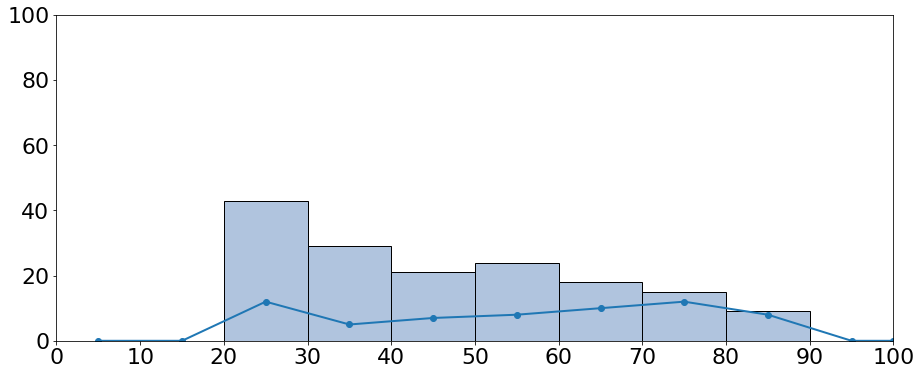

In [369]:
f, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.bar(bins, preds_count, align="edge", width=0.1, color=lightblue, edgecolor="black")
ax.plot([(bins[i] + bins[i+1]) / 2 for i in range(len(bins)-1)]+[1], counts, linewidth=2, marker='o')
ax.set_xlim(0.0, 1.0)
ax.set_ylim(0, 100)
plt.xticks(np.arange(0, 1.1, 0.1))
ax.set_xticklabels(range(0, 110, 10))

# how many predictions in each bin ?

In [ ]:
"""
per ciascun bin abbiamo le probabilità predette dal modello
es 50-60 probabilità predette dal 50% al 60%. la barra indica quanti soggetti hanno avuto una prob predetta in quel 
range. vogliamo che in quel range, circa il 50/60% dei soggetti abbia effettivamente l'evento
il nostro modello sembra ok con le probabilità più alte e scadente con quelle basex
"""

In [220]:
y_nc, x_nc = calibration_curve(y_test, pos_class_proba, n_bins=10)

array([0.25884704, 0.33964187, 0.45931748, 0.54777564, 0.66279546,
       0.74927895, 0.82791653])

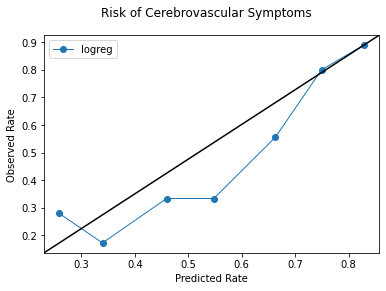

In [18]:
import matplotlib.ticker as mtick

# calibration curves
fig, ax = plt.subplots()
plt.plot(x_nc, y_nc, marker='o', linewidth=1, label='logreg')

# reference line, legends, and axis labels
line = mlines.Line2D([0, 1], [0, 1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
fig.suptitle('Risk of Cerebrovascular Symptoms')
ax.set_xlabel('Predicted Rate')
ax.set_ylabel('Observed Rate')
plt.legend()
plt.show() # it's not rendered correctly on GitHub, check blog post for actual pic

In [23]:
train_ns = pd.read_csv("../input/train.csv")
X_train_ns, y_train_ns = train_ns.drop('symptoms', axis=1), train_ns['symptoms']
X_train_ns.drop(["site", "patient_ID", "infarct_side", "stroke"], axis=1, inplace=True)

le = LabelEncoder()
oe = OrdinalEncoder()

to_encode = ["TIA", "hypertension", "cad", "gender",
             "diabetes", "hyperlipidemia", "smoker_status",
             "prs_either", 
             #'prs_left', 'prs_right',
             'calc_and_lipids', 'at_least_5_and_stenosis_either',
             #'at_least_5_and_stenosis_left', 'at_least_5_and_stenosis_right'
            ]

to_ohe = ["calcification_type_left", "calcification_type_right" 
          #'stenosis_risk_left', 'stenosis_risk_right'
         ]
prefixes = ["calcification_left", "calcification_right" 
            #'stenosis_risk_left', 'stenosis_risk_right'
           ]
X_train_ns = pd.get_dummies(X_train_ns, 
                   columns=to_ohe, prefix=prefixes)

y_train_ns = le.fit_transform(y_train_ns)
X_train_ns[to_encode] = oe.fit_transform(X_train_ns[to_encode]).astype(np.uint8)

# convert uint8 dtypes to categorical
cat_cols = X_train_ns.select_dtypes(include=np.uint8).columns.tolist()
X_train_ns[cat_cols] = X_train_ns[cat_cols].astype("category")


In [36]:
X_test_base, y_test_base = X_test.copy(), y_test.copy()

le = LabelEncoder()
oe = OrdinalEncoder()

to_encode = ["TIA", "hypertension", "cad", "gender",
             "diabetes", "hyperlipidemia", "smoker_status",
             "prs_either", 
             #'prs_left', 'prs_right',
             'calc_and_lipids', 'at_least_5_and_stenosis_either',
             #'at_least_5_and_stenosis_left', 'at_least_5_and_stenosis_right'
            ]

to_ohe = ["calcification_type_left", "calcification_type_right" 
          #'stenosis_risk_left', 'stenosis_risk_right'
         ]
prefixes = ["calcification_left", "calcification_right" 
            #'stenosis_risk_left', 'stenosis_risk_right'
           ]
X_test_base = pd.get_dummies(X_test_base, 
                   columns=to_ohe, prefix=prefixes)

y_test = le.fit_transform(y_test)
X_test_base[to_encode] = oe.fit_transform(X_test_base[to_encode]).astype(np.uint8)

# convert uint8 dtypes to categorical
cat_cols = X_test_base.select_dtypes(include=np.uint8).columns.tolist()
X_test_base[cat_cols] = X_test_base[cat_cols].astype("category")

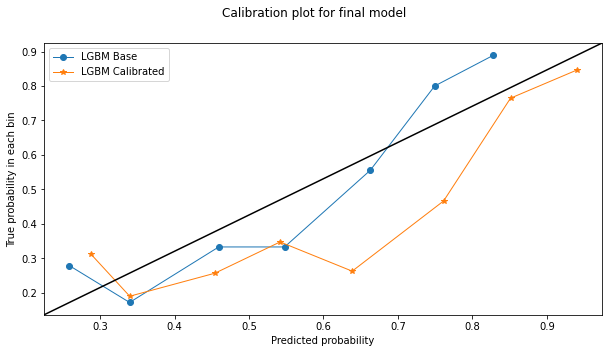

In [66]:
from sklearn.calibration import CalibratedClassifierCV

lgbm_cali = CalibratedClassifierCV(model, cv=10, method="isotonic", n_jobs=1)

lgbm_cali.fit(X_train_ns, y_train_ns)

pos_class_proba_base = model.predict_proba(X_test_base)[:, 1]
pos_class_proba_cali = lgbm_cali.predict_proba(X_test_base)[:, 1]

y_nc, x_nc = calibration_curve(y_test, pos_class_proba_base, n_bins=10)
y_c, x_c = calibration_curve(y_test, pos_class_proba_cali, n_bins=10)

# calibration curves
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(x_nc, y_nc, marker='o', linewidth=1, label='LGBM Base')
ax.plot(x_c, y_c, marker='*', linewidth=1, label='LGBM Calibrated')

# reference line, legends, and axis labels
line = mlines.Line2D([0, 1], [0, 1], color='black')

transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
    
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')

fig.suptitle('Calibration plot for final model')
plt.legend()
plt.show() # it's not rendered correctly on GitHub, check blog post for actual pic